# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

te = pd.read_csv('data/tennis.csv')
te = te.fillna(0.)

surfaces = list(set(list(te.surface)))
for surface in surfaces:
    te[surface] = te['surface'].map(lambda row: 1 if row == surface else 0)
    
te[surfaces + ['player1 total points won']]
# te.columns
y = te['player1 total points won']

x = sm.add_constant(te[surfaces])
model = sm.OLS(y,x).fit(cov_type='HC2')
model.summary()

/home/jlmy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.062
Model:                                  OLS   Adj. R-squared:                  0.058
Method:                       Least Squares   F-statistic:                     966.2
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                              17:06:51   Log-Likelihood:                -5955.6
No. Observations:                      1179   AIC:                         1.192e+04
Df Residuals:                          1173   BIC:                         1.195e+04
Df Model:                                 5                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             53.6325      1.003     53.477      0.000      51.667      55.598
Indoor: Hard      12.5357      2.027      6.184      0.000       8.563      16.509
Indoor: Carpet     8.7886      4.246      2.070      0.038       0.467      17.111
Outdoor: Grass    38.9247      3.016     12.906      0.000      33.014      44.836
Indoor: Clay     -53.6325      1.003    -53.477      0.000     -55.598     -51.667
Outdoor: Hard     24.2348      1.767     13.718      0.000      20.772      27.697
Outdoor: Clay     22.7812      2.425      9.396      0.000      18.029      27.533
==============================================================================
Omnibus:                       21.727   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.333
Skew:                          -0.261   Prob(JB):                     3.15e-06
Kurtosis:                       3.493   Cond. No.                     2.25e+15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 2.98e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### 1. Coeffs and p-values

It is worth noting our R squares i very low, variations are high around the predictors. However, this should not pose a problem since tennis games are trully never "predictable", per-se.

##### Coeffs
Two main things stand out: Indoor: Clay court is the only negative coefficient when predicting points, whereas Indoor: Carpet is the smallest coefficient. These coefficients indicate, in a positive coeffococase, that the more Federer plays on a positive coefficient surface (such as Grass), then more he is likely to score points or as many points as before on average . Contrarily, should he keep playing on negative coefficient surfaces, he will likely score less and less points  on average. This means Federer in consistently underperforming on Indoor Carpet courts, wheras he is performing consistently on all other types of courts. 

##### P-value
On the other hand, the Carpet court's p-value is the only non-zero p-value and s above our $\alpha = 0.01$, meaning we should not reject the null jupothesis for Carpet courts, and should disregard carpet courts as significant predictors.

In [211]:
te.surface.value_counts()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Indoor: Clay        6
Name: surface, dtype: int64

In fact, we can assume this since the number of Indoor: Clay and Indoor: Carpet games are not numerous to be significant. We'll exclude those, let's isolate the most significant surfaces

In [212]:
def filter_down_surfaces(te, remove=[], add_constant=True):
    tec = te.copy()
    for rem in remove:        
        tec = tec[tec.surface != rem]
    y = tec['player1 total points won']
    surfaces = list(set(list(tec.surface)))
    print(tec.surface.value_counts())
    for surface in surfaces:
        tec[surface] = tec['surface'].map(lambda row: 1 if row == surface else 0)
    x = tec[surfaces]
    if add_constant:
        x = sm.add_constant(tec[surfaces])
    model = sm.OLS(y,x).fit(cov_type='HC2')
    summary = model.summary2()
    table = summary.tables[1]
    table = table[table['P>|z|'] > 0.01]
    if table.count()['P>|z|'] > 0:
        return filter_down_surfaces(te, list(table.index),add_constant=add_constant)
    return model

model2 = filter_down_surfaces(te, ['Indoor: Carpet'])
model2.summary()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Clay        6
Name: surface, dtype: int64


/home/jlmy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.058
Model:                                  OLS   Adj. R-squared:                  0.055
Method:                       Least Squares   F-statistic:                     1167.
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                              17:06:53   Log-Likelihood:                -5562.1
No. Observations:                      1103   AIC:                         1.113e+04
Df Residuals:                          1098   BIC:                         1.116e+04
Df Model:                                 4                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             52.1677      0.841     62.040      0.000      50.520      53.816
Indoor: Hard      14.0004      1.898      7.376      0.000      10.280      17.721
Outdoor: Grass    40.3894      2.874     14.055      0.000      34.757      46.022
Indoor: Clay     -52.1677      0.841    -62.040      0.000     -53.816     -50.520
Outdoor: Hard     25.6995      1.637     15.695      0.000      22.490      28.909
Outdoor: Clay     24.2460      2.292     10.577      0.000      19.753      28.739
==============================================================================
Omnibus:                       24.257   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.667
Skew:                          -0.277   Prob(JB):                     3.61e-07
Kurtosis:                       3.582   Cond. No.                     1.44e+15
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 7.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We now only have zero-value p-values for surfaces which we should consider. However, we can see now that by having removed some values for surfaces, our $R^2$ has gone down by 0.004, indicating our fit might not be as accurate (although ever so slightly).

Despite this, our p-values being non-zero and bellow our alpha of 0.01, we can reject the null hypothessis for Outdoor Clay, Grass, Hard and Indoor Hard and Clay surfaces.

We now see see that the highest coefficient, is for Outdoor Grass at 40.3894. This suggests, should Federer play on Outdoor Grass, it is very likely he will score more 2.8 times more points than on Indoor hard surfaces, 

#### 2. Constant Term
Let's proceed by removing Constant Terms.

In [213]:
model3 = filter_down_surfaces(te, [], add_constant=False)
model3.summary()

Outdoor: Hard     482
Outdoor: Clay     249
Indoor: Hard      226
Outdoor: Grass    140
Indoor: Carpet     76
Indoor: Clay        6
Name: surface, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.062
Model:                                  OLS   Adj. R-squared:                  0.058
Method:                       Least Squares   F-statistic:                       nan
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):                nan
Time:                              17:06:54   Log-Likelihood:                -5955.6
No. Observations:                      1179   AIC:                         1.192e+04
Df Residuals:                          1173   BIC:                         1.195e+04
Df Model:                                 5                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Indoor: Hard      66.1681      2.084     31.746      0.000      62.083      70.253
Indoor: Carpet    62.4211      4.882     12.787      0.000      52.853      71.989
Outdoor: Grass    92.5571      3.365     27.502      0.000      85.961      99.153
Indoor: Clay            0          0        nan        nan           0           0
Outdoor: Hard     77.8672      1.721     45.249      0.000      74.494      81.240
Outdoor: Clay     76.4137      2.612     29.256      0.000      71.294      81.533
==============================================================================
Omnibus:                       21.727   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.333
Skew:                          -0.261   Prob(JB):                     3.15e-06
Kurtosis:                       3.493   Cond. No.                         8.96
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

We can tell right away that by ommitting the Constant Term, we've increased our $R^2$ by 0.004, which is not significant. This is expected since our predictor is the type of court surface, which is not a continuous variable, but a qualitative one.

Additionally, we can also tell that not having the constant terms does not change the difference in coefficients in any significant way. The mean of points per surface type is shown rather than the difference between the points mean per surface courts.

Therefore, adding or ommiting the Constant Term has no impact on prediction or fit.

#### 3. T-Test

In [214]:
from scipy.stats import ttest_ind_from_stats
top2 = model3.params.sort_values(ascending=False).nlargest(2)
top2
df = pd.DataFrame({
    'Court': list(top2.index)
})
te[te.surface == 'Outdoor: Grass']
df['NSize'] = df.Court.apply(lambda x: te[te.surface == x].surface.count())
df['CMean'] = df.Court.apply(lambda x: te[te.surface == x]['player1 total points won'].mean())
df['CVar'] = df.Court.apply(lambda x: te[te.surface == x]['player1 total points won'].var())

first = df.iloc[0]
second = one = df.iloc[1]
_, pvalue = ttest_ind_from_stats(mean1=first.CMean, std1=np.sqrt(first.CVar), nobs1=first.NSize,
                     mean2=second.CMean, std2=np.sqrt(second.CVar), nobs2=second.NSize)
if pvalue <= 0.01:
    print("We reject the null hypothesis, the top two coeffs are statistically significantly different")
else:
    print("We accept the null hypothesis, the top two coeffs are not statistically significantly different")
pvalue

We reject the null hypothesis, the top two coeffs are statistically significantly different


7.085417056631752e-05

# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

In [215]:
import seaborn as sns

ti = sns.load_dataset('titanic')
values = {
    'who': {
        'man': 0,
        'woman': 1,
        'child': 2
    },
    'sex': {
        'male': 1,
        'female': 0
    },
    'alone':{False: 0, True: 1},
    'adult_male':{False: 0, True: 1},
}

"""
Only works if the list has no duplicates
"""
def remove_from_cols(df, remove=[]):
    return list(set(df.columns.tolist()) - set(remove))

def dummy_ize_data(df, vmap):
    dft = df.copy()
    for mapping in vmap.keys():
        dft[mapping] = dft[mapping].map(vmap[mapping])

    for categoricals in ['embark_town','class','embarked','deck']:
        uniques = dft[categoricals].value_counts().index.tolist()
        vmap[categoricals] = {uniques[i]: i  for i in range(len(uniques))}
        dft[categoricals] = dft[categoricals].map(vmap[categoricals])
    return dft

def slim_data(df):
    if df[df['alive'] == df['survived']]['survived'].count() == df['survived'].count():
        dft = df.copy()
        return dft.drop(columns=['alive'])
    return df
ti

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [216]:
ttc = dummy_ize_data(ti, values)

In [217]:
"""
We'll be dropping "alive" since we're looking at who survived.
.. you can only be alive if you survived...
"""
titanic = slim_data(ttc)
titanic = titanic.drop(columns=['alive'])
titanic = titanic.fillna(0.)
# titanic = titanic.dropna()

#### Since most of our potential predictors are boolean variables, and, or, categorical variables, and since our prediction is for a boolean value (survived or did not survive) it would be wiser to use categorical values only to predict a passenger's likelihood of survivability.

#### A reason for this is, as one will see, there is no significant trend on several multi-value categorical predictors such as pclass, deck and embarked.

#### We can surmise this logically before demonstrating it:
#### Where someone embarked could be irrelevant, there could be as many rich passengers from Southhampton who boarded and died, as there might have been poor passengers from Cherbourg.
#### As for the deck, we know there are 3 classes of passengers, but there are 6 decks. Are we sure that no deck had more than one class on it?
#### etc...

#### Additionally, we'll isolate predictors who have a p-value of less than 0.1. We'll use 0.1 for now so as not ommit too many predictors.

# 1. Model

In [218]:
y = titanic.survived
cols = remove_from_cols(titanic, ['survived',''])
model = sm.OLS(y,sm.add_constant(titanic[cols].astype(float))).fit(cov_type='HC2')
model.summary()

/home/jlmy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     91.61
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          1.23e-145
Time:                        17:06:59   Log-Likelihood:                -368.69
No. Observations:                 891   AIC:                             763.4
Df Residuals:                     878   BIC:                             825.7
Df Model:                          12                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0590      0.118      8.977      0.000       0.828       1.290
alone          -0.0910      0.038     -2.403      0.016      -0.165      -0.017
age            -0.0015      0.001     -1.878      0.060      -0.003    6.48e-05
parch          -0.0602      0.021     -2.851      0.004      -0.102      -0.019
deck            0.0345      0.014      2.465      0.014       0.007       0.062
fare            0.0007      0.000      2.172      0.030    6.38e-05       0.001
adult_male     -0.4824      0.151     -3.189      0.001      -0.779      -0.186
who             0.0093      0.072      0.130      0.897      -0.131       0.150
sibsp          -0.0783      0.016     -5.029      0.000      -0.109      -0.048
embarked        0.0118      0.010      1.135      0.256      -0.009       0.032
class           0.0214      0.020      1.071      0.284      -0.018       0.061
pclass         -0.1099      0.029     -3.852      0.000      -0.166      -0.054
sex            -0.0593      0.087     -0.683      0.494      -0.229       0.111
embark_town     0.0118      0.010      1.135      0.256      -0.009       0.032
==============================================================================
Omnibus:                       46.842   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.335
Skew:                           0.561   Prob(JB):                     2.62e-12
Kurtosis:                       3.421   Cond. No.                     3.22e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 3.25e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## P-values
First, we notice that many of the p-values are above 0.1, which indicates they're most likely correlated to survability through randomness. We also noticed right away that only one predictor has a p-value of zero, adult_male. We also have several very low-p-values, we will filter out the dataframe to exract these.


In [219]:
cols = remove_from_cols(titanic, ['survived','embark_town','who','class','embarked','sex', 'fare', 'age', 'deck', 'parch', 'alone'])
filtered = sm.OLS(y,sm.add_constant(titanic[cols].astype(float))).fit(cov_type='HC2')
filtered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     324.7
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          3.14e-142
Time:                        17:07:00   Log-Likelihood:                -382.43
No. Observations:                 891   AIC:                             772.9
Df Residuals:                     887   BIC:                             792.0
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1275      0.034     33.112      0.000       1.061       1.194
sibsp         -0.0696      0.012     -5.694      0.000      -0.094      -0.046
adult_male    -0.5680      0.028    -20.056      0.000      -0.624      -0.512
pclass        -0.1581      0.016     -9.729      0.000      -0.190      -0.126
==============================================================================
Omnibus:                       40.294   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.660
Skew:                           0.526   Prob(JB):                     2.01e-10
Kurtosis:                       3.310   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

From this filter, we see that our $R^2$ value has not changed significantly, additionally, our AIC value has only increased by 2.2. We can assume that these 5 predictors can offer significant prediction. One can add or remove "parch" and "alone", only to find that the $R^2$ and AIC do not varry significally. Therefore, we will keep these values to increase our number of factors.

In the end, it makes sense to have these values, as they are all Categorical:

1. alone: boolean
2. sibsp: number of siblings/spouses aboard
3. adult_male: boolean
4. parch: number of parents/children aboard
5. pclass: [1, 2, 3]
6. deck

Looking at these values, one can see that some might be dependent. For example, if someone is alone, they cannot have any other value for parch and sibsp other than 0, which explains why we had no significant effect when removing "parch" and "alone" from the filtered data.

### 2. Coefficients

In [220]:
filtered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     324.7
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          3.14e-142
Time:                        17:07:01   Log-Likelihood:                -382.43
No. Observations:                 891   AIC:                             772.9
Df Residuals:                     887   BIC:                             792.0
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1275      0.034     33.112      0.000       1.061       1.194
sibsp         -0.0696      0.012     -5.694      0.000      -0.094      -0.046
adult_male    -0.5680      0.028    -20.056      0.000      -0.624      -0.512
pclass        -0.1581      0.016     -9.729      0.000      -0.190      -0.126
==============================================================================
Omnibus:                       40.294   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.660
Skew:                           0.526   Prob(JB):                     2.01e-10
Kurtosis:                       3.310   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

What we can see is that all coefficients are negative, save for the deck, and that they're also near zero.
This makes sense since these are all categorical predictors, meaning, a positive step up in unit value means:

2. sibsp: has more family members on board, for each family members a passenger had, they were 6.96% more likely to die
3. adult_male: if a passenger was an adult_male, they were 56.8% more likely to die
5. pclass: for each decrease in class, the passenger wass 15.81% more likely to die

Looking at the passenger distribution according to adult_male, parch and alone:

,pclass,adult_male,count
0,1,False,97
1,1,True,119
2,2,False,85
3,2,True,99
4,3,False,172
5,3,True,319


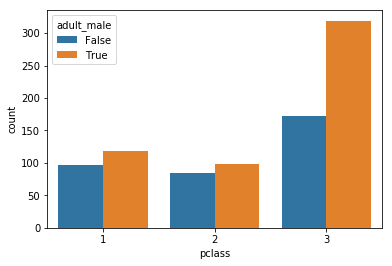

In [221]:
am = pd.DataFrame({'count': ti.groupby(by=['pclass', 'adult_male',]).size()}).reset_index()
sns.barplot(x="pclass", y="count", hue="adult_male", data=am)
am

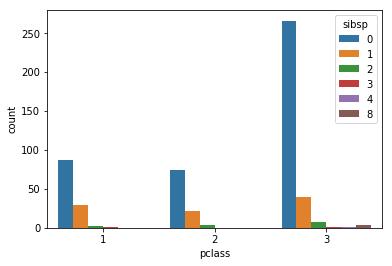

In [222]:
am = pd.DataFrame({'count': ti.groupby(by=['pclass', 'adult_male', 'sibsp']).size()}).reset_index()
sns.barplot(x="pclass", y="count", hue="sibsp", data=am[am['adult_male'] == 1])

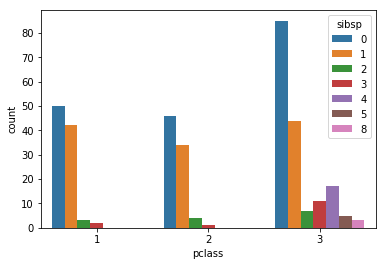

In [223]:
sns.barplot(x="pclass", y="count", hue="sibsp", data=am[am['adult_male'] == 0])

From these we can see that there were more adult males traveling alone to America than any other category of passenger, and these were primarily in Third class. 
This would have been the norm at the time, as sea travel was still a luxurious commodity, where only wealthier families could travel together, and in relative comfort (which explains a more even distribution of non-alone passengers in First and Second class).

Let us know look at passenger class, we saw above that more Third class passengers were traveling alone..

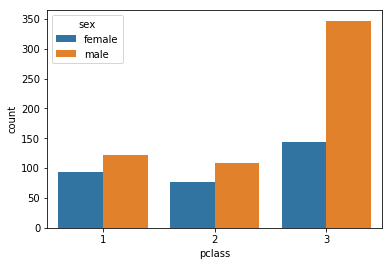

In [224]:
pclass = pd.DataFrame({'count': ti.groupby(by=['pclass', 'sex']).size()}).reset_index()
sns.barplot(x="pclass", y="count", hue="sex", data=pclass)

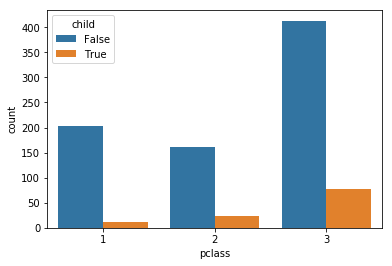

In [225]:
ti['child'] = ti['age'] < 18.
child = pd.DataFrame({'count': ti.groupby(by=['pclass', 'child']).size()}).reset_index()
sns.barplot(x="pclass", y="count", hue="child", data=child)

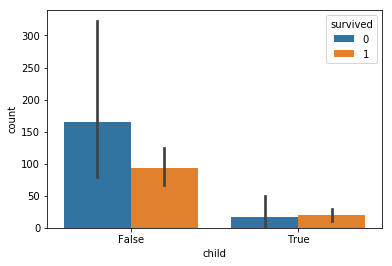

In [226]:
childS = pd.DataFrame({'count': ti.groupby(by=['pclass', 'child', 'survived']).size()}).reset_index()
x = sns.barplot(x="child", y="count", hue="survived", data=childS)

This latter plot shows us that you were almost as likely to die then to survive, if you were a child, which looked much more favorable than if you were not a child (an adult).

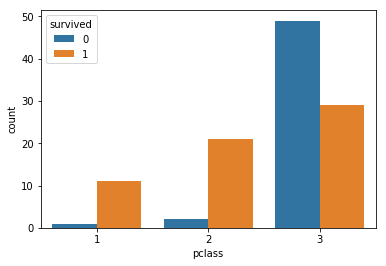

In [227]:
childSurvived = childS[(childS['child'] == True)]
x = sns.barplot(x="pclass", y="count",hue="survived",data=childSurvived)

This graph shows us that it was much more favourable to be a child in a higher class, than to be a child in a lower class.

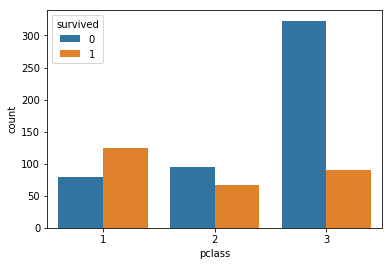

In [228]:
adultsSurvived = childS[(childS['child'] == False)]
x = sns.barplot(x="pclass", y="count", hue="survived",data=adultsSurvived)

Likewise, it was much more favourable to be an adult in first class, than an adult in third class.

### Let's look at how sex played a role:

In [229]:
womenDF = pd.DataFrame({'count': ti.groupby(by=['pclass', 'child', 'sex', 'survived']).size()}).reset_index()
women = womenDF[womenDF['sex'] == 'female']
aWomen = women[women['child'] == False]
cWomen = women[women['child']]
# aWomen

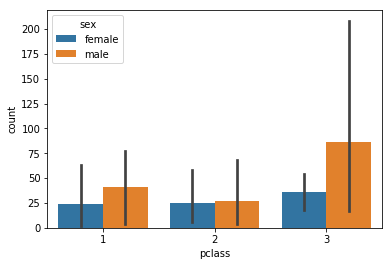

In [230]:
x = sns.barplot(x="pclass", y="count",hue="sex",data=womenDF)

### Adult females

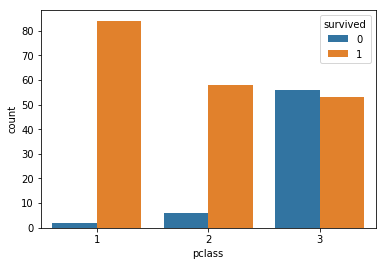

In [231]:
x = sns.barplot(x="pclass", y="count",hue="survived",data=aWomen)

Even more so, here we see that it was in fact better to be a non-adult female that an adult one. Further, it happens to be that none of the non-adult females in second class perished.

#### Male v Female

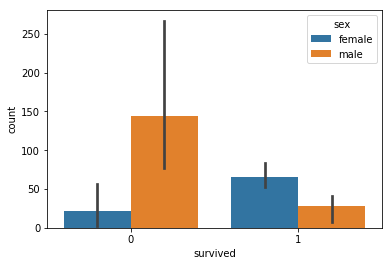

In [232]:
x = sns.barplot(x="survived", y="count",hue="sex",data=womenDF[womenDF['child'] == False])

We can see that in upper classes, being a woman was greatly advantageous, whereas in third class, it was more insignificant.

#### Non-adult females

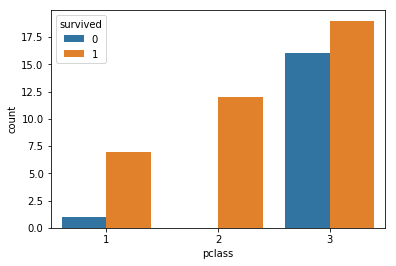

In [233]:
x = sns.barplot(x="pclass", y="count",hue="survived",data=cWomen)

#### Non-Adult Male v Female

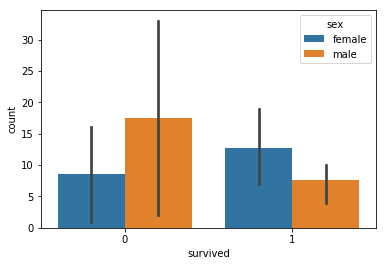

In [234]:
x = sns.barplot(x="survived", y="count",hue="sex",data=womenDF[womenDF['child']])

#### Sex distribution for non-adults

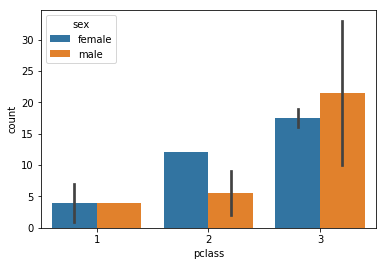

In [235]:
x = sns.barplot(x="pclass", y="count",hue="sex",data=womenDF[womenDF['child']])

We can see that children were relatively evenly distributed amongst genders in the passenger classes, with the exception of second class where there were almost twice as many non adult females as males. This makes the fact that all non-adult females in second class survived remarkable.

This means, that the passenger who was the most likely to survive was:
1. not male
2. not an adult
3. in a passenger class with less children
4. preferrably not in third class

This lends itself well to the notion of women and children being prioritized, and men being considered less important during the evacuation.

Additionally, this implies that surviving the Titanic disproprotionately favored the wealthier first class, notably their female children (second-to-last plot) as lower-income families of the time were more heavily burdened during the evacuation as they had larger families to take care of.
The high concentration of single males in lower classes, also speaks to the post-famine period of the United Kingdom in the early 20th century, as one could imagine, it must have been cheaper, and actually possible, to buy a single ticket as a man, than as a woman Even more so as a single man buying passage for himself, than for his entire family at a time when ocean-crossing travels were still high-technological feats.

## 3. Prediction

The Titanic was said to have had a capacity of more than 2000 passengers. It's maiden and only voyage only had approximately 1317 passengers.

1. alone: boolean
2. sibsp: number of siblings/spouses aboard
3. adult_male: boolean
4. parch: number of parents/children aboard
5. pclass: [1, 2, 3]
6. deck

In [236]:
l = 2000

rand = pd.DataFrame({
    'sibsp': np.random.randint(9, size=l),
    'adult_male': np.random.randint(2, size=l),
    'pclass': np.random.randint(1, 4, size=l),
})
read = rand.copy()
read['yhat'] = filtered.predict(sm.add_constant(rand))
yhat = read['yhat'].map(lambda x: 1 if abs(x) > 0.05 else 0)

# pd.DataFrame({'count': rand.groupby(by=['pclass', 'adult_male', 'sibsp']).size()}).reset_index()

In [237]:
from sklearn.linear_model import LassoCV
from sklearn import metrics
lassoregcv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassoFit = lassoregcv.fit(titanic[cols], y)

lasso = rand.copy() 
lasso['survived'] = lassoFit.predict(rand)
# lassoPredict = list(map(lambda x: 1 if abs(x) > 0.5 else 0, lassoPredict) )
# print(lassoPredict[:891])
# print("R-Square Value",r2_score(y_hat[:891],lassoPredict[:891]))
comps = pd.DataFrame({
    'lasso': lassoFit.coef_,
    'linear': filtered.summary2().tables[1]['Coef.'][1:]
})
comps['delta'] = abs(abs(comps.lasso) - abs(comps.linear))

First, we can notice that our coefficients are very similar to the LRR fit coefficients:

In [238]:
comps

,lasso,linear,delta
sibsp,-0.069270,-0.069579,0.000309
adult_male,-0.567305,-0.567995,0.000690
pclass,-0.157840,-0.158093,0.000252


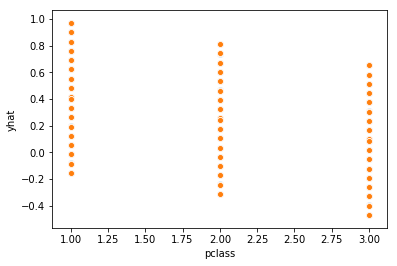

In [239]:
sns.scatterplot(data=lasso, x="pclass", y="survived")
sns.scatterplot(data=read, x="pclass", y="yhat")

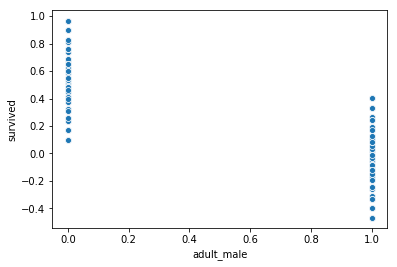

In [240]:
sns.scatterplot(data=lasso, x="adult_male", y="survived")

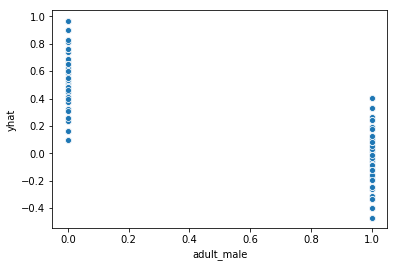

In [241]:
sns.scatterplot(data=read, x="adult_male", y="yhat")

From what we can tell, there is no major improvement to be made by regularizing our regression.

# House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**

Here are the features you can use (or engineer into new features!) for your `X` matrix:

    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: $Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale


In [632]:
import pandas as pd
SaleCondition = ["Normal","Abnorml","Partial","Family","Alloca","AdjLand","Abnormal Sale"]
hs = pd.read_csv('data/house_price.csv')
hs['NewGarage'] = (hs.GarageYrBlt > hs['GarageYrBlt'].describe()['50%']).astype(float)
hs['Has2ndFlr'] = (hs['2ndFlrSF'] > 0).astype(float)
hs['HasPool'] = (hs['PoolArea'] > 0).astype(float)
hs['SaleCondition'] = hs.SaleCondition.apply(lambda x: SaleCondition.index(x)).astype(float)
continuous_vars = [
    'LotFrontage',
    'LotArea',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'HalfBath',
    'FullBath',
    'BsmtHalfBath',
    'BsmtFullBath',
    'GrLivArea',
    'LowQualFinSF',
    '2ndFlrSF',
    '1stFlrSF',
    'Fireplaces',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'MoSold',
    'YrSold',
    'NewGarage',
    'Has2ndFlr',
    'HasPool',
    'OverallQual',
    'OverallCond',
    'TotRmsAbvGrd',
    'GarageCars',
    'SaleCondition'
]
boolean_vars = [
    'CentralAir',
    'GarageYrBlt',
    'HasGarage'
]
quanlitative_vars = list(set(hs.columns) - set(continuous_vars) - set(boolean_vars))
hs = hs[hs.SalePrice <= 398000]
hs = hs[hs['LotArea'] <= hs['LotArea'].describe()['75%']]
hs = hs[hs['YearBuilt'] >= 1960]

hs = hs.fillna(0.)
y = hs.SalePrice

Possible new features:
1. Has garage
2. Has second floor
3. Has masonry veneer
4. Has been remodelled
5. Kitchen
6. KitchenQual
7. IsNew (use SaleCondition == Partial)

8. Has pool (PoolQC == NA)

In [653]:

"""
These are variables we exclude from our initial list of predictors to consider
after looking at their distributions, and the relevance of their outliers
"""
exclude_vars = [
    'HalfBath',
    'FullBath',
    'MiscVal',
    'BsmtHalfBath',
    '3SsnPorch',
    'YrSold',
    'MoSold',
    'LowQualFinSF',
    '2ndFlrSF',
    'OpenPorchSF',
    'PoolArea',
    'GarageYrBlt',
    'WoodDeckSF',
    'ScreenPorch',
    'EnclosedPorch',
    'BsmtFullBath',
    'MasVnrArea',
#     'Fireplaces',
    '1stFlrSF',
    'LotFrontage',
    'NewGarage',
    'HasPool',
    'Has2ndFlr',
    'YearBuilt',
#     'OverallCond',
#     'SaleCondition',
    'Fireplaces',
#     'OverallQual',
#     'OverallCond',
#     'TotRmsAbvGrd',
#     'GarageCars',
#     'SaleCondition',
#     'YearRemodAdd',
    'LotArea'
]


using_cols = list(set(continuous_vars) - set(exclude_vars))
use = hs.copy()
for ft in using_cols:
    use[ft+'_r'] = use[ft] ** 2
    
conths = use[using_cols]

x = sm.add_constant(conths)
y = use.SalePrice
est = sm.OLS(y, x).fit()
corr = conths.corr()
corr = corr > 0.3
est.summary()
# corr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     323.1
Date:                Thu, 21 Jan 2021   Prob (F-statistic):          1.88e-211
Time:                        00:12:53   Log-Likelihood:                -8014.1
No. Observations:                 688   AIC:                         1.604e+04
Df Residuals:                     680   BIC:                         1.608e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.332e+05   1.73e+05     -4.819      0.000   -1.17e+06   -4.94e+05
GarageCars       1.4e+04   2175.917      6.433      0.000    9724.533    1.83e+04
YearRemodAdd    384.8545     89.060      4.321      0.000     209.988     559.721
GrLivArea        62.0007      5.117     12.118      0.000      51.955      72.047
SaleCondition  4122.5427   1370.454      3.008      0.003    1431.713    6813.372
OverallQual    2.075e+04   1423.274     14.581      0.000     1.8e+04    2.35e+04
TotRmsAbvGrd  -3499.0175   1314.828     -2.661      0.008   -6080.628    -917.407
OverallCond    4179.5491   1313.022      3.183      0.002    1601.484    6757.614
==============================================================================
Omnibus:                      119.901   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.423
Skew:                           0.729   Prob(JB):                    1.19e-112
Kurtosis:                       6.982   Cond. No.                     4.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

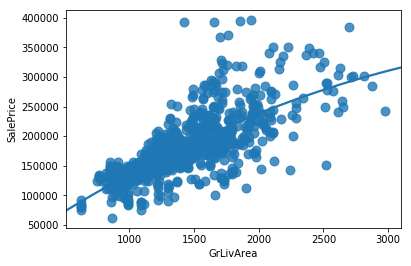

In [665]:
import seaborn as sns
sns.regplot(x="GrLivArea", y="SalePrice", data=use,
                 scatter_kws={"s": 80},
                 order=2, ci=None)

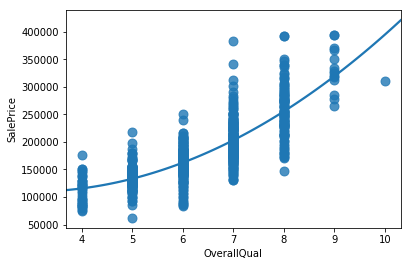

In [656]:
sns.regplot(x="OverallQual", y="SalePrice", data=use,
                 scatter_kws={"s": 80},
                 order=2, ci=None)

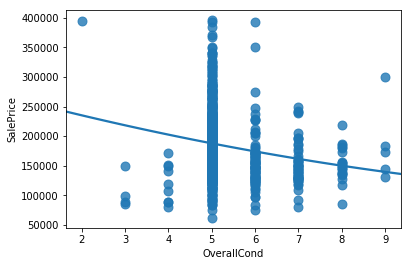

In [657]:
sns.regplot(x="OverallCond", y="SalePrice", data=use,
                 scatter_kws={"s": 80},
                 order=2, ci=None)

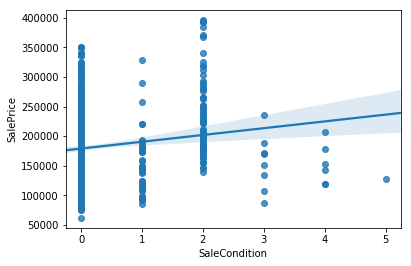

In [658]:
sns.regplot(x="SaleCondition", y="SalePrice", data=use,)

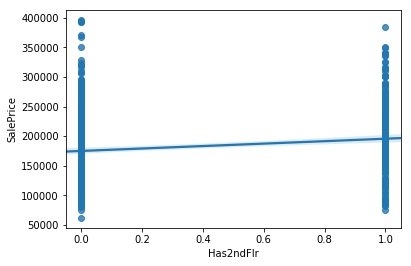

In [659]:
sns.regplot(x="Has2ndFlr", y="SalePrice", data=use,)

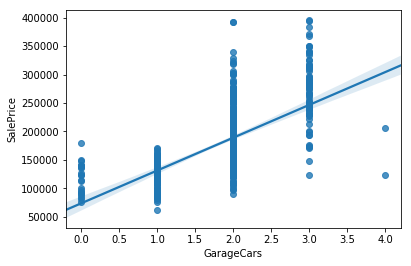

In [660]:

sns.regplot(x="GarageCars", y="SalePrice", data=use)


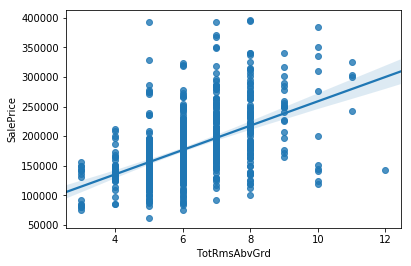

In [661]:
sns.regplot(x="TotRmsAbvGrd", y="SalePrice", data=use)

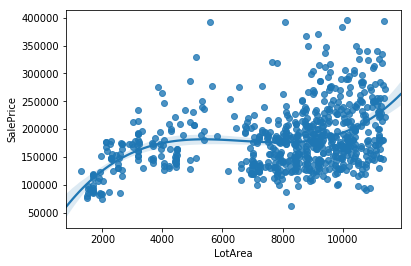

In [662]:
sns.regplot(x="LotArea", y="SalePrice", data=use,order=3)

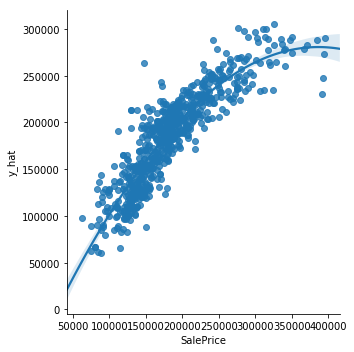

In [663]:
use['y_hat'] = est.predict(x)
sns.lmplot(x="SalePrice", y="y_hat", data=use,order=2)

In [666]:
from sklearn.metrics import r2_score
print(r2_score(y, use['y_hat']))

0.7688151787273626


Our analysis took on the approach that many predictors where subjective factors (such as a the material used for some parts of a home), which are materials that individuals would most likely give different prices to when considering the purchase of a house.
This led to the assumption that, due to this, there must have been a lot of dependence between several columns.
As such:
1. we transformed some continuous predictors into more binary or categorical predictors.
2. we removed entries that had significant outliers in the predictors we were interested in, this in turn, removed some price abnormalities (huge lots, going for much more than lots that were much smaller for example)
3. we did the latter by filtering out only values which were in the first 75% of values.

While our predictions correlate with our observed values with an $R^2$ of 0.76, we might have a multicolinearity problem. For this, let's try applying VIF analysis to extract a small number of predictors who do not have any multicolinearity.

## Using VIF to exclude columns

In [668]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
filt = hs[continuous_vars]
# filt = filt.dropna()
fts = list(filt.columns)
vif = pd.DataFrame({
    'ft': fts
})

def r_s(ft, df):
    x = df[list(set(df.columns) - set([ft]))]
    y = df[ft]
    est = sm.OLS(y,sm.add_constant(x)).fit()
    return est.rsquared

vif['r2'] = vif['ft'].apply(lambda x: r_s(x, filt))

vif['vif'] = vif['r2'].apply(lambda x: 1000 if x == 1 else (1 / (1 - x)))

vif['keep'] = vif['vif'] < 5

hs = hs.fillna(0.)
cols_to_use = vif[vif['keep']]['ft'].tolist()

In [676]:
using_cols = list(set(cols_to_use) - set(exclude_vars))
use2 = hs.copy()
for ft in using_cols:
    use2[ft+'_r'] = use2[ft] ** 2
    
conths = use2[using_cols]

x2 = sm.add_constant(conths)
y2 = use.SalePrice
est2 = sm.OLS(y2, x2).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     333.9
Date:                Thu, 21 Jan 2021   Prob (F-statistic):          1.43e-180
Time:                        00:20:03   Log-Likelihood:                -8092.1
No. Observations:                 688   AIC:                         1.620e+04
Df Residuals:                     682   BIC:                         1.622e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.156e+05   1.22e+04     -9.468      0.000    -1.4e+05   -9.16e+04
GarageCars     1.891e+04   2384.042      7.931      0.000    1.42e+04    2.36e+04
SaleCondition  2775.3760   1505.433      1.844      0.066    -180.464    5731.216
OverallQual    2.998e+04   1303.293     23.007      0.000    2.74e+04    3.25e+04
TotRmsAbvGrd   8245.5541    926.621      8.899      0.000    6426.182    1.01e+04
OverallCond    3650.0514   1456.685      2.506      0.012     789.925    6510.177
==============================================================================
Omnibus:                       89.899   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.860
Skew:                           0.677   Prob(JB):                     1.00e-51
Kurtosis:                       5.522   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

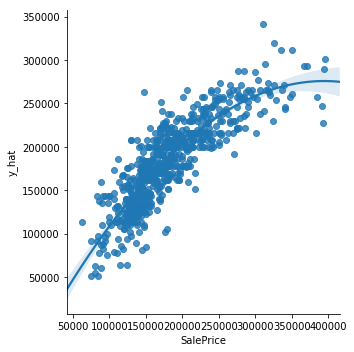

In [677]:
use2['y_hat'] = est2.predict(x)
sns.lmplot(x="SalePrice", y="y_hat", data=use2,order=2)

In [678]:
print(r2_score(y, use2['y_hat']))

0.7099561995687076
